## SQL запросы к Elasticsearch

In [1]:
import pandas as pd
import pandasticsearch as ps
from elasticsearch import Elasticsearch
import plotly.graph_objects as go
import plotly.express as px
import time

Вспомогательная функция **sql_result_to_dataframe**(sql_res) 
преобразует результат выполнения SQL запроса в Dataframe

In [2]:
def sql_result_to_dataframe(sql_res):
    """ Преобразует результат выполнения SQL запроса в Dataframe
    """
    rows = sql_res['rows']
    cols = sql_res['columns']
    col_names = [c['name'] for c in cols]
    return pd.DataFrame.from_records(rows,columns=col_names)

In [3]:
def update_data(sql):
    result = ps_client.post({'query':sql})
    return sql_result_to_dataframe(result)
    
    
def update_plot(figure_widget,sql):
    dataframe = update_data(sql)
    bar = figure_widget.data[0]
    bar.x = dataframe['interval']
    bar.y = dataframe['count']
    bar.text = bar.y.tolist()

def update_plot_several_times(figure_widget,sql, times, delay=5):
    for i in range(times):
        update_plot(figure_widget,sql)
        figure_widget.layout.title = f'Request {i}/{times}'
        time.sleep(delay)        

Задаем конечную точку Elasticsearch и текст SQL запроса

In [34]:
elastic_url = 'http://es01:9200/'

sql = '''
SELECT HISTOGRAM(date_modified, INTERVAL 1 HOUR) as interval, count(*) as count FROM articles GROUP by interval ORDER BY interval DESC LIMIT 100 
'''

Создаем соединения с базой данных

In [35]:
ps_client = ps.RestClient(elastic_url, '_sql')

In [36]:
dataframe = update_data(sql)
# display(dataframe.head(3))

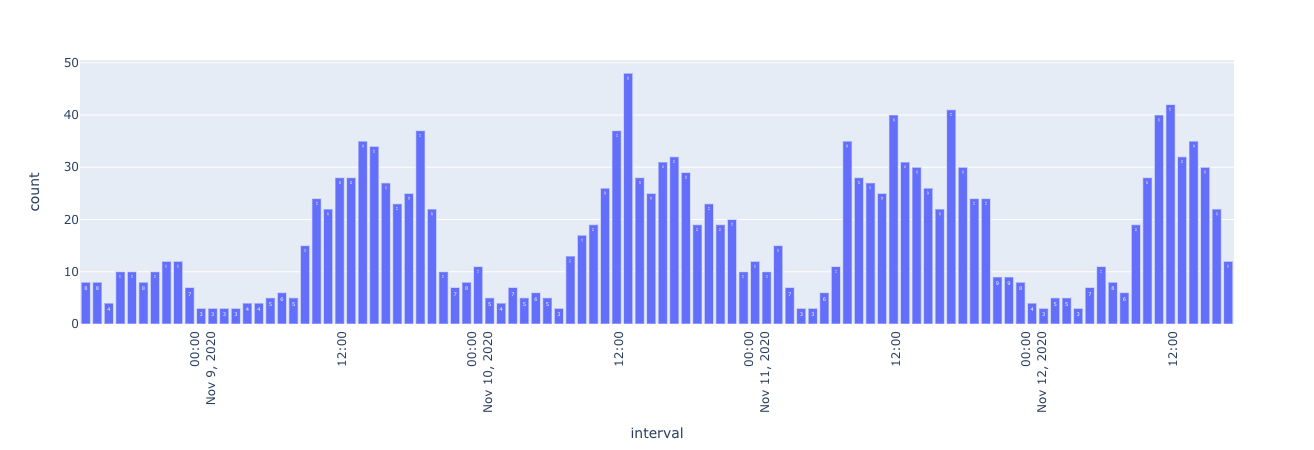

In [53]:
fig = px.bar(dataframe, x='interval', y='count', text='count')
fig.update_layout(xaxis_tickangle=-90)
display(fig)

In [64]:
fw = go.FigureWidget()

# fw = fig
fw.add_bar(textposition='auto')
fw.layout.title = 'Request'

display(fw)
# update_plot_several_times(fw,sql, 10,2)
fw.layout.title = 'Done'


FigureWidget({
    'data': [{'textposition': 'auto', 'type': 'bar', 'uid': 'afc713bd-ea20-44a1-bf0b-89e19c0f5d…